In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import argparse
import subprocess
import os
from scipy.spatial import cKDTree
from netCDF4 import Dataset, default_fillvals

load 25km domain file

In [77]:
domain_25km_filename = 'domain.lnd.wr25b_ar9v4.170413.nc'
direc = '/Users/diana/Dropbox/UW/Research/rasm/25_km'
domain_25km = Dataset(os.path.join(direc, domain_25km_filename), 'r+')
lon_25km = domain_25km.variables['xc'][:,:]
lat_25km = domain_25km.variables['yc'][:,:]
mask_25km = domain_25km.variables['mask'][:,:]

load 50km domain file

In [78]:
domain_50km_filename = 'domain.lnd.wr50a_ar9v4.100920.nc'
domain_50km = Dataset(os.path.join(direc, domain_50km_filename))
lon_50km = domain_50km.variables['xc'][:,:]
lat_50km = domain_50km.variables['yc'][:,:]
mask_50km = domain_50km.variables['mask'][:,:]

This is the function used for converting lat/lon to x, y, z: 

In [79]:
def lon_lat_to_cartesian(lon, lat, R = 1):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)

    return x, y, z

convert lat/lon to the Cartesian CRS

In [80]:
# lon, lat from meshgridded coarser res data
xs, ys, zs = lon_lat_to_cartesian(lon_50km.flatten(), lat_50km.flatten()) 
# lon, lat directly from xc, yc from higher res data
xt, yt, zt = lon_lat_to_cartesian(lon_25km.flatten(), lat_25km.flatten()) 

create `cKDTree` object to represent source grid

In [81]:
# poly = mpl.path.Path(list(zip(listx, listy)))
import matplotlib as mpl
zipped_25km = np.dstack(([xs, ys, zs]))[0]
tree = cKDTree(zipped_25km)

nearest neighbor interpolation

In [82]:
# find indices of the nearest neighbors in the flattened array 
zipped_50km = np.dstack(([xt, yt, zt]))[0]
d, inds = tree.query(zipped_50km, k=1)

get interpolated 2d field

In [83]:
mask_nearest = mask_50km.flatten()[inds].reshape(lon_25km.shape)

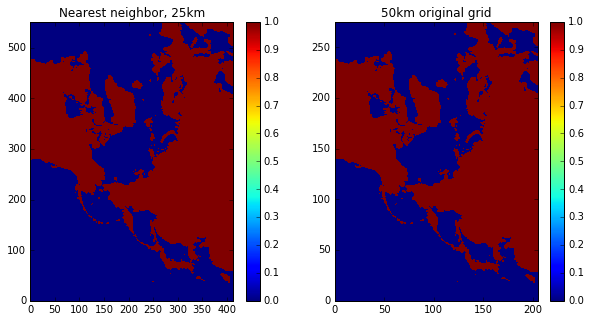

In [84]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.pcolormesh(mask_nearest.transpose())
plt.xlim([0, mask_nearest.shape[0]])
plt.ylim([0, mask_nearest.shape[1]])
plt.colorbar()
plt.title("Nearest neighbor, 25km")

plt.subplot(122)
plt.pcolormesh(mask_50km.transpose())
plt.xlim([0, mask_50km.shape[0]])
plt.ylim([0, mask_50km.shape[1]])
plt.colorbar()
plt.title("50km original grid")

try the same thing with only the land lats/lons

In [85]:
lat_25km_land = lat_25km[mask_25km > 0]
lon_25km_land = lon_25km[mask_25km > 0]
mask_25km_land = mask_25km[mask_25km > 0]
nj_inds_25km, ni_inds_25km = np.nonzero(mask_25km)

lat_50km_land = lat_50km[mask_50km > 0]
lon_50km_land = lon_50km[mask_50km > 0]
mask_50km_land = mask_50km[mask_50km > 0]
nj_inds_50km, ni_inds_50km = np.nonzero(mask_50km)

In [86]:
# lon, lat from meshgridded coarser res data
xs, ys, zs = lon_lat_to_cartesian(lon_50km_land, lat_50km_land) 
# lon, lat directly from xc, yc from higher res data
xt, yt, zt = lon_lat_to_cartesian(lon_25km_land, lat_25km_land)

In [87]:
zipped_25km = np.dstack(([xs, ys, zs]))[0]
tree = cKDTree(zipped_25km)

In [88]:
# find indices of the nearest neighbors in the flattened array 
zipped_50km = np.dstack(([xt, yt, zt]))[0]
d, inds = tree.query(zipped_50km, k=1)

In [89]:
mask_nearest = mask_50km.flatten()[inds]

In [90]:
domain_25km

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: CESM domain data:
    Conventions: CF-1.0
    source_code: SVN $Id: gen_domain.F90 41914 2012-11-13 21:58:37Z mlevy@ucar.edu $
    SVN_url:  $URL: https://svn-ccsm-models.cgd.ucar.edu/tools/mapping/gen_domain/trunk/src/gen_domain.F90 $
    Compiler_Optimized: FALSE
    hostname: geyser03
    history: created by tcraig, 2017-04-13 19:33:31
    source: /glade/p/cesmdata/cseg/inputdata/cpl/cpl6/map_ar9v4_TO_wr25b_aave.170413.nc
    map_domain_a: /glade/p/cesmdata/cseg/mapping/grids/ar9v4_100920.nc
    map_domain_b: /glade/p/cesmdata/cseg/mapping/grids/wr25b_170413.nc
    map_grid_file_ocn: /glade/p/cesmdata/cseg/mapping/grids/ar9v4_100920.nc
    map_grid_file_atm: /glade/p/cesmdata/cseg/mapping/grids/wr25b_170413.nc
    dimensions(sizes): n(227563), ni(551), nj(413), nv(4)
    variables(dimensions): float64 xc(nj,ni), float64 yc(nj,ni), float64 xv(nj,ni,nv), float64 yv(nj,ni,nv), in

In [97]:
domain_25km['mask_interp'][:,:] = mask_25km[:,:]

In [101]:
print(len(nj_inds_25km))
print(len(inds))
# ni_inds_25km

100805
100805


In [103]:
domain_25km['mask_interp'][:,:][nj_inds_25km, ni_inds_25km] = mask_nearest 

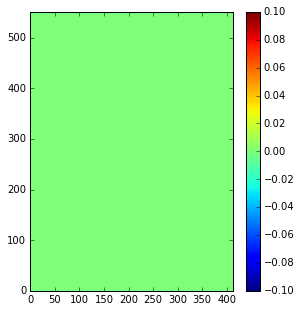

In [105]:
masks_subtracted = domain_25km['mask_interp'][:,:] - domain_25km['mask'][:,:]

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.pcolormesh(masks_subtracted.transpose())
plt.xlim([0, masks_subtracted.shape[0]])
plt.ylim([0, masks_subtracted.shape[1]])
plt.colorbar()
# plt.title("Nearest neighbor, 25km")